In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import pyvisa
from typing import Union, Any
from pprint import pprint

from qick import *
from qick.averager_program import QickSweep
from qick.pyro import make_proxy

rm = pyvisa.ResourceManager()
visa_addr = "USB0::0x0957::0x1780::MY60101437::0::INSTR"
oscilloscope = rm.open_resource(visa_addr)
print(oscilloscope.query("*IDN?"))
oscilloscope.write(":TIMebase:RANGe 0.00005")

c:\Users\Measurement1\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AGILENT TECHNOLOGIES,DSO-X 6004A,MY60101437,07.31.2020012834



25

In [3]:
class PowerMeas(AveragerProgram):
    def initialize(self):
        freq_rf     = self.cfg["freq_rf"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        self.declare_gen(
            ch      = 2,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = self.cfg["duration"] + 100       # Readout length
        )
        # Convert RF frequency to DAC DDS register value
        freq_dac    = self.freq2reg(
            f       = freq_rf,  # Frequency
            gen_ch  = 0,        # Generator channel
            ro_ch   = 0         # Readout channel for round up
        )
        # Convert RF frequency to ADC DDS register value
        freq_adc    = self.freq2reg_adc(
            f       = freq_rf,  # Frequency
            ro_ch   = 0,        # Readout channel
            gen_ch  = 0         # Generator channel for round up
        )

        # Set DAC DDS
        self.set_pulse_registers(
            ch      = 0,        # Generator channel
            style   = "const",  # Output is gain * DDS output
            freq    = freq_dac, # Generator DDS frequency
            phase   = 0,        # Generator DDS phase
            gain    = 2500,      # Generator amplitude
            length  = self.cfg["duration"], # Pulse length
            phrst   = 0,        # Generator DDS phase reset
            mode    = "periodic"
        )
        self.set_pulse_registers(
            ch      = 2,        # Generator channel
            style   = "const",  # Output is gain * DDS output
            freq    = freq_dac, # Generator DDS frequency
            phase   = 0,        # Generator DDS phase
            gain    = self.cfg["gain"],      # Generator amplitude
            length  = self.cfg["duration"], # Pulse length
            phrst   = 0,        # Generator DDS phase reset
            mode    = "periodic"
        )
        # Set ADC DDS
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = freq_adc, # Readout DDS frequency
            length  = self.cfg["duration"], # Readout DDS multiplication length
            phrst   = 0         # Readout DDS phase reset
        )
        self.synci(100)

    def body(self):
        self.pulse(
            ch      = 0,        # Generator channel
            t       = 100       # Pulse will be output @ sync_t + 100
        )
        self.pulse(
            ch      = 2,        # Generator channel
            t       = 100       # Pulse will be output @ sync_t + 100
        )
        self.readout(
            ch      = 0,        # Readout channel
            t       = 100       # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        self.trigger(
            adcs    = [0],      # Readout channels
            adc_trig_offset = 50 # Readout will capture the data @ sync_t + 50
        )
        self.sync_all(100)

def measure_pwr(
    freq:Union[float,int],
    gain:int,
    soc:Any,
    soccfg:QickConfig
) -> float:
    oscilloscope.write_termination = "\n"
    oscilloscope.read_termination = "\n"

    # Set input impedance
    oscilloscope.write(":CHAN4:IMP FIFT")
    freq = int(freq)
    cfg = {
        # Experiment Setup
        "reps" : 1,
        "duration" : 1500,
        "expts" : 1,
        "freq_rf" : freq,
        "gain" : gain
    }
    prog = PowerMeas(
        soccfg,
        cfg
    )
    prog.acquire(soc, progress = False)

    # Set function operation as fft
    oscilloscope.write(":FUNC1:DISP ON")
    oscilloscope.write(":FUNC1:OPER FFT")
    oscilloscope.write(":FUNC1:SOUR CHAN4")
    oscilloscope.write(f":FUNC1:CENT {freq} MHz")
    oscilloscope.write(":FUNC1:SPAN 100 MHz")
    oscilloscope.write(":SYST:PREC ON")
    oscilloscope.write(":MARK:MODE WAV")
    oscilloscope.write(":MARK:X1Y1Source MATH1")
    oscilloscope.write(f":MARK:X1Position {freq} MHz")
    time.sleep(1)
    pwr = 0
    for i in range(100):
        pwr += float(oscilloscope.query(":MARK:Y1Position?"))
    pwr = pwr / 100

    return pwr

In [266]:

soc.rfb_set_gen_rf(0, 10, 10)
soc.rfb_set_gen_rf(2, 0, 0)
# resp = oscilloscope.query(":TIMebase:RANGe?")
# oscilloscope.write(":TIMebase:RANGe 0.00005")
print(measure_pwr(500, 0, soc, soccfg))
print(measure_pwr(500, 0, soc, soccfg))
print(measure_pwr(500, 10, soc, soccfg))
print(measure_pwr(500, 100, soc, soccfg))
print(measure_pwr(500, 1000, soc, soccfg))
print(measure_pwr(500, 10000, soc, soccfg))

-38.3203125000141
-35.546875000013216
-35.000000000014126
-35.9375000000141
-17.95859375001366
1.914062499986093


Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_23fdec74fbd8437babb43b88cba8d231@192.168.2.99:34619


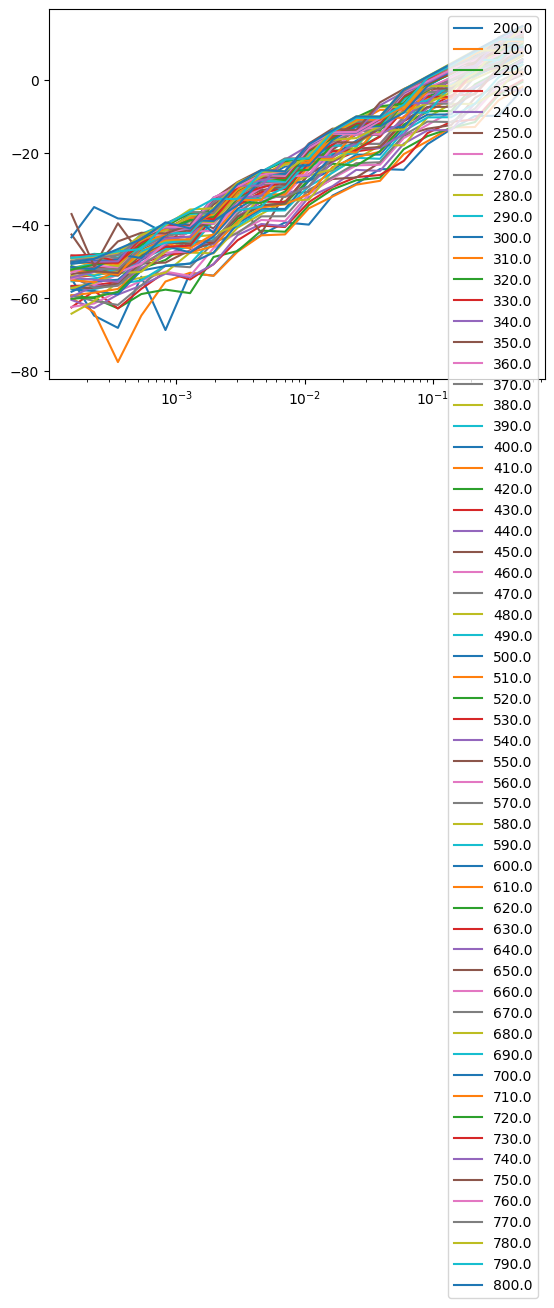

In [7]:
# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

att1 = 0
att2 = 0
# Set DAC Channel 0 attenuation 10 dB and 10 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0, 10, 10)
soc.rfb_set_gen_rf(2, att1, att2)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")
soc.rfb_set_gen_filter(2,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,31)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

frequencies = np.linspace(200, 800, 61)
gains = np.logspace(np.log10(10),np.log10(32767),20).astype(int)
data = {}

for freq in frequencies:
    data[freq] = {}
    for gain in gains:
        data[freq][gain] = measure_pwr(
            freq = freq,
            gain = gain,
            soc = soc,
            soccfg = soccfg
        )
import json
import matplotlib.pyplot as plt

plt.figure()
att1 = 0
att2 = 0

for freq in frequencies:
    gain = data[freq].keys()
    gain = [x/2**16 for x in gain]
    pwr = data[freq].values()
    plt.plot(gain, pwr, label = freq)
plt.xscale("log")
plt.legend()
plt.show()
json_data = {str(k) : {str(i) : j for i, j in v.items()} for k, v in data.items()}
file_name = f"pwr_map_{frequencies[0]}MHz_{frequencies[-1]}MHz.json"
with open(file_name, "w", encoding = "utf-8") as f:
    json.dump(json_data, f, indent = 4, ensure_ascii=False)

In [8]:
measure_pwr(500, 0, soc, soccfg)

-36.3671875000141

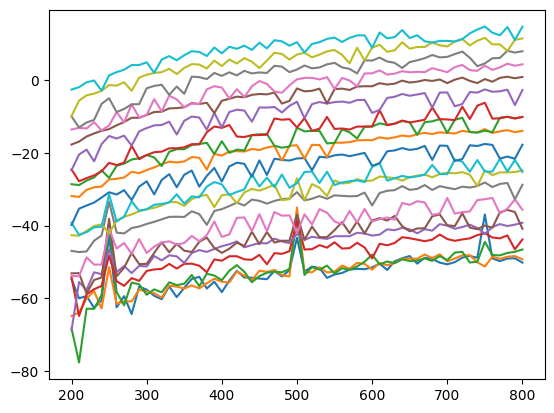

In [26]:
plt.figure()
for idx, x in enumerate(gain):
    pwr = []
    for freq in frequencies:
        pwr.append(list(data[freq].values())[idx])
    plt.plot(frequencies, pwr, label = float(x) * 2)
# plt.legend()
plt.show()